In [57]:
import sys
import os
from matplotlib import pyplot as plt
import tensorflow.compat.v2 as tf
import functools
from absl import logging
import pandas as pd
import numpy as np
import functools
import albumentations as A
import tensorflow_addons as tfa

In [2]:
def convert(img, target_type_min=0, target_type_max=255, target_type='uint8'):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [3]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
def bulid_input_fn(global_batch_size):
    #Build input function.
    #Args:
    #    global_batch_size: Global batch size.
    #Returns:
    #    A function that accepts a dict of params and returns a tuple of images and
    #    features, to be used as the input_fn in TPUEstimator.
    def _input_fn_(input_context):
        #Inner input function
        batch_size = input_context.get_per_replica_batch_size(global_batch_size)
        logging.info('Global batch size: %d', global_batch_size)
        logging.info('Per-replica batch size: %d', batch_size)
        preprocess_fn_pretrain = get_preprocess_fn(True, is_pretrain=True)
        num_classes = 5

        def map_fn(image, label):
            #Produces multiple transformations of the same batch for pretraining
            xs = []
            for _ in range(2):
                xs.append(preprocess_fn_pretrain(image))
            image = tf.concat(xs, -1)
            label = tf.one_hot(label, num_classes)
            return image, label

        logging.info('Using Astro pretrain data')
        dataset = get_data_train()

        if input_context.num_input_pipelines > 1:
            dataset = dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)

        dataset = dataset.shuffle(batch_size * 10)
        dataset = dataset.repeat(-1)
        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    return _input_fn_

def build_distributed_dataset(batch_size, strategy):
    input_fn = bulid_input_fn(batch_size)
    return strategy.distribute_datasets_from_function(input_fn)

def get_preprocess_fn(is_training, is_pretrain):
    #Get function that accepts an image and returns a preprocessed image
    test_crop=True
    return functools.partial(
        preprocess_image,
        height = 330,
        width= 330,
        color_distort=is_pretrain)


def get_data_train():
    logging.info('Loading Astro pretrain data')
    data_dir = '/home/pedri0/Documents/imagenes_no_clasificadas_desi/'
    def read_images(image_file, label):
        image = tf.io.read_file(data_dir + image_file)
        image = tf.image.decode_jpeg(image, channels = 3)
        return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    df = pd.read_csv('/home/pedri0/Documents/GitHub/Modified-SimCLR/SimCLRTF2/galaxies_train.csv')
    file_paths = df['name'].values
    labels = tf.zeros([df.shape[0]], dtype=tf.int64)
    ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_train = ds_train.map(read_images, num_parallel_calls =AUTOTUNE)
    return ds_train

In [126]:
@tf.function
def invert(image):
    #Inverts the pixel of a tensor image only float32 are supported

    #Args.
        #image: float tensor of shape (height, width, channels)

    #Returns.
        #procesed image
    inverted_image = 1. - image
    return inverted_image

@tf.function
def solarize(image, threshold = 0.5):
    #Inverts the pixels of a tensor image above threshold only float32 are supported

    #Args.
        #image: float tensor of shape (height, width, channels)
        #threshold:: float number for setting inversion pixel threshold

    #Returns.
        #solarized image
    threshold = tf.cast(threshold, tf.float32)
    inverted_image = invert(image)
    solarized_image = tf.where(image < threshold, image, inverted_image)
    return solarized_image

@tf.function
def solarize_plus_invert(image):
    #solarizes tensor image above threshold, then invert it

    #Args.
        #image: float tensor of shape (height, width, channels)

    #Returns.
        #inverted solarized image
    solarized = solarize(image, threshold = 0.5)
    return invert(solarized)
    

@tf.function
def solarize_add_or_substract(image, threshold, add = True, number=0.5):
    #Add or substract number to each pixel and Inverts the pixels of a tensor 
    #image above threshold. Only float32 are supported

    #Args.
        #image: float tensor of shape (height, width, channels)
        #threshold: float number for setting inversion pixel threshold
        #add: boolean, if true add number to each pixel, else substract number
        #number: float number to be added or substracted

    #Returns.
        #solarized added or substracted image
    number = tf.cast(number, tf.float32)

    if add :
        transformed_image = image + number
    else:
        transformed_image = image - number
    
    black , white = tf.constant(0., tf.float32), tf.constant(1., tf.float32)
    transformed_image = tf.clip_by_value(transformed_image, clip_value_min=black, clip_value_max=white)

    return solarize(transformed_image, threshold)

@tf.function
def auto_contrast(image):
    #Normalize image contrast by remapping the image histogram such that 
    #the brightest pixel becomes 1.0 and darkest becomes 0.0

    #Args.
        #image: float tensor of shape (height, width, channels)

    #Returns.
        #autocontrasted image

    min_val, max_val = tf.reduce_min(image, axis=[0, 1]), tf.reduce_max(image, axis=[0, 1])
    normalized_image = (image - min_val) / (max_val - min_val)
    normalized_image = tf.image.convert_image_dtype(normalized_image, tf.float32, saturate=True)
    return normalized_image

@tf.function
def blend(image_a, image_b, factor):
    #Blend image_a with image_b

    #Args.
        #image_a: float tensor of shape (height, width, channels)
        #image_b: float tensor of shape (height, width, channels)
        #factor: float > 0 weight for combining the images

    #Returns.
        #Blended image
    if factor <= 0.0:
        return image_a

    elif factor >= 1.0:
        return image_b
    
    else:
        scaled_diff = (image_b - image_a) * factor
        blended_image = image_a + scaled_diff

        blended_image = tf.image.convert_image_dtype(blended_image, tf.float32, saturate=True)

        return blended_image

@tf.function
def color(image, magnitude):
    #modify the magnitude of color of an image tensor

    #Args.
        #image: float tensor of shape (height, width, channels)
        #magnitude: float > 0 magnitude for modifying the color of the image

    #Returns.
        #modified image
    #gray = tf.image.rgb_to_grayscale(image)
    gray = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))
    colored = blend(gray, image, magnitude)
    return colored

@tf.function
def sharpness(image, magnitude):
    #modify the magnitude of sharpness of an image tensor

    #Args.
        #image: float tensor of shape (height, width, channels)
        #magnitude: float > 0 magnitude for modifying the sharpness of the image

    #Returns.
        #modified image
    image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
    image = tf.cast(image, tf.float32)

    blur_kernel = tf.constant([[1, 1, 1], [1, 5, 1], [1, 1, 1]], 
        tf.float32, shape = [3, 3, 1, 1]) / 13
    blur_kernel = tf.tile(blur_kernel, [1, 1, 3, 1])
    strides = [1, 1, 1, 1]

    #extract blurred image with the kernel
    blurred_image = tf.nn.depthwise_conv2d(image[None, ...], blur_kernel, strides, padding='VALID')
    blurred_image = tf.clip_by_value(blurred_image, 0., 255.)
    blurred_image = blurred_image[0]

    mask = tf.ones_like(blurred_image)
    padding = tf.constant([[1 ,1], [1, 1], [0, 0]], tf.int32)
    mask = tf.pad(mask, padding)
    padded_image = tf.pad(blurred_image, padding)

    blurred_image = tf.where(mask==1, padded_image, image)

    sharpened_image = blend(blurred_image, image, magnitude)
    sharpened_image = tf.cast(sharpened_image, tf.uint8)
    sharpened_image = tf.image.convert_image_dtype(sharpened_image, tf.float32)
    return sharpened_image

@tf.function
def posterize(image, bits):
    #Reduces the number of bits in an image tensor for each channel

    #Args.
        #image: float tensor of shape (height, width, channels)
        #bits: number of bitsto use

    #Returns.
        #posterized image
    image = tf.image.convert_image_dtype(image, tf.uint8)

    bits = tf.cast(bits, tf.int32)
    mask = tf.cast(2 ** (8-bits) - 1, tf.uint8)
    #invert mask
    mask = tf.bitwise.invert(mask)

    posterized_image = tf.bitwise.bitwise_and(image, mask)
    posterized_image = tf.image.convert_image_dtype(posterized_image, tf.float32, saturate=True)
    return posterized_image

@tf.function
def equalize(image):
    #Equalizes the histogram of tensor image individually per channel

    #Args.
        #image: float tensor of shape (height, width, channels)
        
    #Returns.
        #Equalized image
    image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
    image = tf.cast(image, tf.int32)

    def equalize_channel(image_channel):
        #Equalizes the histogram of a 2D image
        bins = tf.constant(256, tf.int32)
        histogram = tf.math.bincount(image_channel, minlength = bins)
        nonzero = tf.where(tf.math.not_equal(histogram, 0))
        nonzero_histogram = tf.reshape(tf.gather(histogram, nonzero), [-1])
        step = (tf.reduce_sum(nonzero_histogram) - nonzero_histogram[-1]) // (bins - 1)

        def normalize(histogram, step):
            normalized_histogram = (tf.math.cumsum(histogram) + (step // 2)) // step
            normalized_histogram = tf.concat([[0], normalized_histogram], axis = 0)
            normalized_histogram = tf.clip_by_value(normalized_histogram, 0, bins - 1)
            return normalized_histogram

        return tf.cond(tf.math.equal(step, 0),
                lambda: image_channel,
                lambda: tf.gather(normalize(histogram, step), image_channel))
    channels_first = tf.transpose(image, [2, 0, 1])
    channels_first_equalized_image = tf.map_fn(equalize_channel, channels_first)
    equalized_image = tf.transpose(channels_first_equalized_image, [1, 2, 0])

    equalized_image = tf.cast(equalized_image, tf.uint8)
    equalized_image = tf.image.convert_image_dtype(equalized_image, tf.float32)
    return equalized_image
    
@tf.function
def darker(image,number=0.5):
    #substract number to each pixel tensor image
    #Only float32 are supported

    #Args.
        #image: float tensor of shape (height, width, channels)
        #number: float number to be added or substracted

    #Returns.
        #darker image
    number = tf.cast(number, tf.float32)

    darker_image = image - number
    
    black , white = tf.constant(0., tf.float32), tf.constant(1., tf.float32)
    darker_image = tf.clip_by_value(darker_image, clip_value_min=black, clip_value_max=white)

    return darker_image
    


    channels_first = tf.transpose(image, [2, 0, 1])
    channels_first_equalized_image = tf.map_fn(equalize_channel, channels_first)
    equalized_image = tf.transpose(channels_first_equalized_image, [1, 2, 0])

    equalized_image = tf.cast(equalized_image, tf.uint8)
    equalized_image = tf.image.convert_image_dtype(equalized_image, tf.float32)
    return equalized_image

def functions_rand(image):

    def apply_transform(i, x):

        def auto_contrast_foo():
            return auto_contrast(x)

        def color_foo():
            return color(x, magnitude = tf.random.uniform([], 0.1, 1.0))

        def sharpness_foo():
            return sharpness(x, magnitude = tf.random.uniform([], 0, 1.0))

        def posterize_foo():
            return posterize(x, bits = tf.cast(tf.random.uniform([], 4, 9), tf.int8))
    
        x = tf.cond(tf.less(i,2),
            lambda: tf.cond(tf.less(i, 1), auto_contrast_foo, color_foo),
            lambda: tf.cond(tf.less(i, 3), sharpness_foo, posterize_foo))

        return x

    perm = tf.random.shuffle(tf.range(4))

    for element in range(4):
        image = apply_transform(perm[element], image)
        image = tf.clip_by_value(image, 0., 1.)
    
    return image

@tf.function
def sobel_x_t(image):
    #Gets sobel dx filter for an image tensor

    #Args.
        #image: float tensor of shape (height, width, channels)

    #Returns.
        # sobel filter dx or dy depending on random number
    
    sobel_x = tf.constant([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], tf.float32, shape = [3, 3, 1, 1])
    sobel_x = tf.tile(sobel_x, [1, 1, 3, 1])
    
    pad_sizes = tf.constant([[1, 1], [1, 1], [0, 0]], tf.int32)
    padded = tf.pad(image, pad_sizes, mode='REFLECT')
    strides = [1,1,1,1]
    sobel = tf.nn.depthwise_conv2d(padded[None, ...], sobel_x, strides, padding='VALID')
    sobel = tf.clip_by_value(sobel, 0., 1.)
    sobel = sobel[0]
    #sobel = tf.image.convert_image_dtype(sobel, tf.uint8)
    
    return sobel

@tf.function
def sobel_y_t(image):
    #Gets sobel filter dy for an image tensor

    #Args.
        #image: float tensor of shape (height, width, channels)

    #Returns.
        # sobel filter dy
    
    sobel_y = tf.constant([[1, 0, -1], [2, 0, -2], [1, 0, -1]], tf.float32, shape = [3, 3, 1, 1])
    sobel_y = tf.tile(sobel_y, [1, 1, 3, 1])
    
    pad_sizes = tf.constant([[1, 1], [1, 1], [0, 0]], tf.int32)
    padded = tf.pad(image, pad_sizes, mode='REFLECT')
    
    
    strides = [1,1,1,1]
    sobel = tf.nn.depthwise_conv2d(padded[None, ...], sobel_y, strides, padding='VALID')
    sobel = tf.clip_by_value(sobel, 0., 1.)
    sobel = sobel[0]
    #sobel = tf.image.convert_image_dtype(sobel, tf.uint8)

    return sobel

@tf.function
def sobel_edges(image):
    #Gets only one image from sobel filter dx or dy

    #Args.
        #image: float tensor of shape (height, width, channels)

    #Returns.
        # sobel filter dx or dy depending on random number
    
    #random_integer = tf.cast(tf.random.uniform([], 0, 2), tf.int8)
    image = tfa.image.gaussian_filter2d(image, sigma=15.0)

    #image = tf.cond(tf.less(random_integer, 1),
    #        lambda: sobel_x_t(image),
    #        lambda: sobel_y_t(image))
    x = sobel_x_t(image)
    y = sobel_y_t(image)
    x = tf.math.square(x)
    y = tf.math.square(y)

    return tf.math.sqrt(x+y)#image

In [163]:
import functools


def random_apply(func, p, x):
    #Random apply function funt to x with probability p.
    return tf.cond(
        tf.less(
            tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
            tf.cast(p, tf.float32)
        ), lambda: func(x), lambda: x
    )

def random_brightness(image, max_delta):
    factor = tf.random.uniform([], tf.maximum(1.0 - max_delta, 0),1.0 + max_delta)
    image = image * factor
    return image

def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.tile(image, [1, 1, 3])
    return image

def color_jitter(image, strength):
    #Distorts the color of the image.

    #Args:
        #image: The input image tensor.
        #strength: the floating number for the strength of the color augmentation.
        #random_order: A bool, specifying whether to randomize the jittering order.

    #Returns: The distorted image tensor.
    brightness = 0.8 * strength
    contrast = 0.8 * strength
    saturation = 0.8 * strength
    hue = 0.2 * strength
    return color_jitter_rand(image, brightness, contrast, saturation, hue)

def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
    #Distorts the color of the image (jittering order is random).

    #Args.
        #image: The input image tensor.
        #brightness: A float, specifying the brightness for color jitter.
        #contrast: A float, specifying the contrast for color jitter.
        #saturation: A float, specifying the saturation for color jitter.
        #hue: A float, specifying the hue for color jitter.

    #Returns.
        #The distorted image tensor.

    with tf.name_scope('distort_color'):

        def apply_transform(i, x):
           #Apply the i-th transformation
            def brightness_foo():
                if brightness == 0:
                    return x
                else:
                    return random_brightness(x, max_delta=brightness)
            
            def contrast_foo():
                if contrast == 0:
                    return x
                else:
                    return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
            
            def saturation_foo():
                if saturation == 0:
                    return x
                else:
                    return tf.image.random_saturation(x, lower=1-saturation, upper=1+saturation)
                
            def hue_foo():
                if hue == 0:
                    return x
                else:
                    return tf.image.random_hue(x, max_delta=hue)
            
            x = tf.cond(tf.less(i, 2),
                    lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                    lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
            
            return x

        perm = tf.random.shuffle(tf.range(4))
        for i in range(4):
            image = apply_transform(perm[i], image)
            image = tf.clip_by_value(image, 0., 1.)

        return image

def distorted_bounding_box_crop(image, bbox, min_object_covered=0.1, aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0), max_attempts=100, scope=None):
    #Generates cropped_image using one of the bboxes randomly distorted.
    
    #Args:
        #image: `Tensor` of image data.
        #bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
            # where each coordinate is [0, 1) and the coordinates are arranged
            # as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole image
        # min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
            # area of the image must contain at least this fraction of any bounding box supplied.
        # aspect_ratio_range: An optional list of `float`s. The cropped area of the
            #image must have an aspect ratio = width / height within this range.
        #area_range: An optional list of `float`s. The cropped area of the image
            #must contain a fraction of the supplied image within in this range.
        #max_attempts: An optional `int`. Number of attempts at generating a cropped
            #region of the image of the specified constraints. After `max_attempts`
            #failures, return the entire image.
        #scope: Optional `str` for name scope.
    
    #Returns:
        #(cropped image `Tensor`, distorted bbox `Tensor`).

    with tf.name_scope(scope or 'distorted_bounding_box_crop'):
        shape = tf.shape(image)
        sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
            shape,
            bounding_boxes=bbox,
            min_object_covered=min_object_covered,
            aspect_ratio_range=aspect_ratio_range,
            area_range=area_range,
            max_attempts=max_attempts,
            use_image_if_no_bounding_boxes=True)
        bbox_begin, bbox_size, _ = sample_distorted_bounding_box

        # Crop the image to the specified bounding box.
        offset_y, offset_x, _ = tf.unstack(bbox_begin)
        target_height, target_width, _ = tf.unstack(bbox_size)
        image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, target_height, target_width)

        return image

def crop_and_resize(image, height, width):
    #Make a random crop and resize it to height `height` and width `width`.

    #Args:
        #image: Tensor representing the image.
        #height: Desired image height.
        #width: Desired image width.

    #Returns:
        #A `height` x `width` x channels Tensor holding a random crop of `image`.
    
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    aspect_ratio = width / height
    image = distorted_bounding_box_crop(
        image,
        bbox,
        min_object_covered=0.2,
        aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
        area_range=(0.2, 1.0),
        max_attempts=100,
        scope=None)
    
    return tf.image.resize([image], [height, width], method=tf.image.ResizeMethod.BICUBIC)[0]

def random_crop_with_resize(image, height, width, p=1.0):
    #Randomly crop and resize an image.

    #Args:
        #image: `Tensor` representing an image of arbitrary size.
        #height: Height of output image.
        #width: Width of output image.
        #p: Probability of applying this transformation.

    #Returns:
        #A preprocessed image `Tensor`.
    
    def _transform(image):
        image = crop_and_resize(image, height, width)
        return image
    
    return random_apply(_transform, p=p, x=image)

def random_color_jitter(image, p=1.0):

    def _transform(image):
        color_jitter_t = functools.partial(color_jitter, strength=0.6)
        image = random_apply(color_jitter_t, p=0.8, x=image)
        return random_apply(to_grayscale, p=0.2, x=image)
    
    return random_apply(_transform, p=p, x=image)

In [143]:
#def random_darker(image, p=1.0):
#    
#    def _transform(image):
#        darker_t = functools.partial(darker, number=tf.random.uniform([], 0, 0.19))
#        return random_apply(darker_t, p=0.8, x=image)
#    return random_apply(_transform, p=p, x=image)

def random_darker(image, p):
    darker_t = functools.partial(darker, number=tf.random.uniform([], 0, 0.19))
    return random_apply(darker_t, p=p, x=image)

def random_solarize(image, p):
    solarize_t = functools.partial(solarize, threshold =0.5)#tf.random.uniform([], 0.4, 0.7))
    return random_apply(solarize_t, p=p, x=image)

def random_invert(image, p):
    return random_apply(invert, p=p, x=image)

def random_solarize_plus_invert(image, p):
    return random_apply(solarize_plus_invert, p=p, x=image)

def random_sobel(image, p):
    return random_apply(sobel_edges, p=p, x=image)

In [164]:
def preprocess_for_train(image, height, width, color_distort=True):
    #Preprocesses the given image for training.

    #Args.
        #image: `Tensor` representing an image of arbitrary size.
        #height: Height of output image.
        #width: Width of output image.
        #color_distort: Whether to apply the color distortion.
        #crop: Whether to crop the image.
    
    #Returns.
        #A preprocessed image `Tensor`.
    
    image = random_crop_with_resize(image, height, width)
    image = random_darker(image, p=0.65)
    #image = random_sobel(image, p=1.0)
    image = functions_rand(image)
    image = random_color_jitter(image)
    #image = random_solarize(image, p=0.8)
    #image = random_invert(image, p=0.8)
    image = random_solarize_plus_invert(image, p = 0.2)
    image = random_sobel(image, p=0.2)
    image  = tf.image.random_flip_left_right(image)
    image  = tf.image.random_flip_up_down(image)
    #image = invert(image)
    image = tf.reshape(image, [height, width, 3])
    image = tf.clip_by_value(image, 0., 1.)

    return image

def preprocess_image(image, height, width, color_distort=True):
    #Preprocesses the given image.

    #Args.
        #image: `Tensor` representing an image of arbitrary size.
        #height: Height of output image.
        #width: Width of output image.
        #color_distort: Whether to apply the color distortion.
    
    #Returns.
        #A preprocessed image `Tensor` of range [0, 1].

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.central_crop(image, 0.65)
    return preprocess_for_train(image, height, width, color_distort)

In [165]:
ds_train = build_distributed_dataset(16, strategy)

/home/pedri0/anaconda3/envs/SIM/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/pedri0/anaconda3/envs/SIM/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/home/pedri0/anaconda3/envs/SIM/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


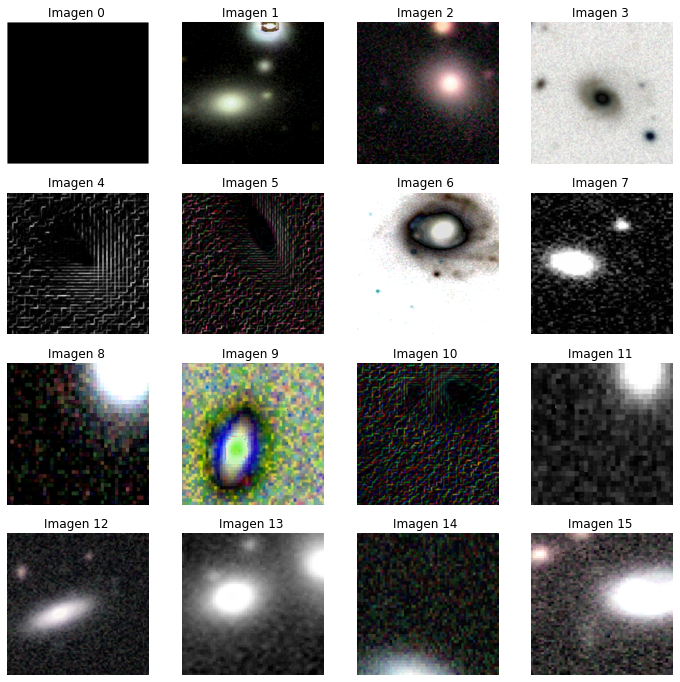

In [174]:
image_batch, label_batch = next(iter(ds_train))
images_from_0to3=[]
images_from_0to6=[]
for i in range(16):
    img1 = convert(image_batch[i,:,:,:3].numpy())
    img2 = convert(image_batch[i,:,:,3:].numpy())
    images_from_0to3.append(img1)
    images_from_0to6.append(img2)
plt.figure(figsize=(12, 12))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to3[i])
  #label = label_batch[i]
  plt.title('Imagen {} '.format(i))
  plt.axis("off")

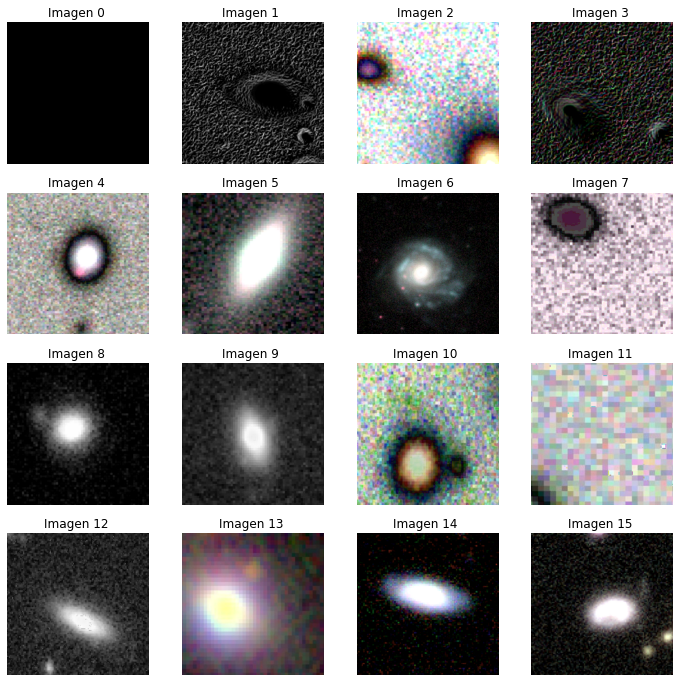

In [175]:
plt.figure(figsize=(12, 12))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images_from_0to6[i])
  #label = label_batch[i]
  plt.title('Imagen {} '.format(i))
  plt.axis("off")